<h1 align="center"> Matching Vendor Name by Using NLP and Random Forest </h1>

<h2> Problem Statement: </h2>

Due to the large volume of transactions and lack of dedicated resources, Finance department relies on P-Card holders and district P-Card Coordinators to identify, track and resolve P-Card disputes. To address this challenge, I develope a model piepline which can automatically identify merchant names. By implementing this model, the Finance department can determine whether P-Card holders are in compliance with P-Card policies and procedure.

<h2>Workflow: </h2>
<br>1. Data Preprocessing
<br>2. Exploratory Data Analysis
<br>3. Model Developement& Optimization
<br>4. Model Evaluation
<br>5. Model Implementation


In [1]:
# Imported Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import time
import string
string.punctuation
import re
import sys
import hashlib # import hash library to has employee information
from sklearn.model_selection import train_test_split # import train and test split for model training and testing
from sklearn.feature_extraction.text import TfidfVectorizer # import TF-IDF for model developement
from sklearn.ensemble import RandomForestClassifier # import random forest for model developement
from sklearn.pipeline import make_pipeline # import data pipeline for model developement
from sklearn.preprocessing import LabelEncoder # import label encoder for model developement
from sklearn.metrics import classification_report # import classification report for model evaluation 
from sklearn.metrics.pairwise import cosine_similarity # import cosine_similairty for model evaluation 

<h2 align="center"> 1. Data Preprocessing </h2>

In [2]:
# load  2021 to 2022 P-card transactions data
df_pcard = pd.read_csv("Transactions Approval 2021 to 2022.csv")

In [3]:
# Check dataset rows and columns
df_pcard.shape

(17238, 35)

In [4]:
# Check dataset information to have a basic examination
df_pcard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17238 entries, 0 to 17237
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   FIN.FINANCIAL TRANSACTION IDENTIFIER     17238 non-null  int64  
 1   ACC.EMPLOYEE ID                          17238 non-null  int64  
 2   ACC.DEPARTMENT                           15564 non-null  object 
 3   ACC.ACCOUNT NAME                         17238 non-null  object 
 4   ACC.ACCOUNT NUMBER                       17238 non-null  object 
 5   FIN.TRANSACTION DATE                     17238 non-null  object 
 6   FIN.POSTING DATE                         17238 non-null  object 
 7   MCH.MERCHANT NAME                        17238 non-null  object 
 8   FIN.EXPENSE DESCRIPTION                  14383 non-null  object 
 9   FIN.ORIGINAL CURRENCY AMOUNT             17238 non-null  object 
 10  FIN.TAX AMOUNT                           17238

In [5]:
# Hash ACC.EMPLOYEE ID to protect employee information

df_pcard['ACC.EMPLOYEE ID'] = df_pcard['ACC.EMPLOYEE ID'].astype(str).apply(lambda x: hashlib.sha256(x.encode()).hexdigest())

print(df_pcard[['ACC.EMPLOYEE ID']])

                                         ACC.EMPLOYEE ID
0      a6a4ba2d0f1375ed0b82381a1f16be0968c11fb67ca361...
1      9de8ccf0ac26aece4633556cdd7ab7e77bf9ed505dfcb5...
2      9de8ccf0ac26aece4633556cdd7ab7e77bf9ed505dfcb5...
3      08494e72f5bf74296af076dfb7ef2eb47660ba2cfaf3bf...
4      8cbd379ad47781e6299bd8eb5d4542f05b2b8b876452e8...
...                                                  ...
17233  ddc761bbf4d141bc0d83d53abea1f93fcfc40a8f1b25aa...
17234  fd458a3e933098e9a87052c29f9fd0e0000822aec1048f...
17235  fd458a3e933098e9a87052c29f9fd0e0000822aec1048f...
17236  b8c3aaba4f8e9d4314fe3fed576fe697490469e19bf50e...
17237  c191d5586f1e08c76063fe105cec98da077bd26ef9508e...

[17238 rows x 1 columns]


In [6]:
# Check missing values
df_pcard.isnull().sum()

FIN.FINANCIAL TRANSACTION IDENTIFIER           0
ACC.EMPLOYEE ID                                0
ACC.DEPARTMENT                              1674
ACC.ACCOUNT NAME                               0
ACC.ACCOUNT NUMBER                             0
FIN.TRANSACTION DATE                           0
FIN.POSTING DATE                               0
MCH.MERCHANT NAME                              0
FIN.EXPENSE DESCRIPTION                     2855
FIN.ORIGINAL CURRENCY AMOUNT                   0
FIN.TAX AMOUNT                                 0
FIN.ACCOUNTING CODE 02 VALUE                7700
FIN.ACCOUNTING CODE 04 VALUE                   0
FIN.ACCOUNTING CODE 05 VALUE                   1
FIN.ACCOUNTING CODE 06 VALUE                   1
FIN.ACCOUNTING CODE 07 VALUE                   1
FIN.ACCOUNTING CODE 08 VALUE                   1
FIN.ACCOUNTING CODE 09 VALUE                   2
FIN.APPROVED                                   0
FIN.APPROVED DATE                            461
FIN.APPROVED BY USER

In [7]:
# Based upon domain knowledge, removing below columns

# Select indices for the specific column3 and column4
col_indicies_3and4 = [3, 4]

# Select the indices for the last 25 columns
last_cols_indices = list(range(len(df_pcard.columns) - 25, len(df_pcard.columns)))

# Combine both lists of indices
cols_to_drop_indices = col_indicies_3and4 + last_cols_indices

# Drop the columns from the DataFrame using the combined indices list
df_pcard = df_pcard.drop(df_pcard.columns[cols_to_drop_indices], axis=1)


In [8]:
# Check dataset again to make sure all functions apply
df_pcard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17238 entries, 0 to 17237
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   FIN.FINANCIAL TRANSACTION IDENTIFIER  17238 non-null  int64 
 1   ACC.EMPLOYEE ID                       17238 non-null  object
 2   ACC.DEPARTMENT                        15564 non-null  object
 3   FIN.TRANSACTION DATE                  17238 non-null  object
 4   FIN.POSTING DATE                      17238 non-null  object
 5   MCH.MERCHANT NAME                     17238 non-null  object
 6   FIN.EXPENSE DESCRIPTION               14383 non-null  object
 7   FIN.ORIGINAL CURRENCY AMOUNT          17238 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.1+ MB


In [9]:
# Change 'FIN.ORIGINAL CURRENCY AMOUNT' data type from object to float for further analysis.
df_pcard['FIN.ORIGINAL CURRENCY AMOUNT'] = pd.to_numeric(df_pcard['FIN.ORIGINAL CURRENCY AMOUNT'], errors='coerce')

In [10]:
# Revise column names:
df_pcard.rename(columns={
    'FIN.FINANCIAL TRANSACTION IDENTIFIER': 'financial_transaction_id',
    'ACC.EMPLOYEE ID': 'employee_id',
    'ACC.DEPARTMENT': 'department',
    'ACC.ACCOUNT NAME': 'account_name',
    'FIN.TRANSACTION DATE': 'transaction_date',
    'FIN.POSTING DATE': 'posting_date',
    'MCH.MERCHANT NAME': 'merchant_name',
    'FIN.EXPENSE DESCRIPTION': 'expense_description',
    'FIN.ORIGINAL CURRENCY AMOUNT': 'purchase_amount'
}, inplace=True)


### Step1 Key Takeways:
<br>✔️ import raw data and examine dataset
<br>✔️ hash employee_id column to compliance intenral company disclose policy
<br>✔️ check missing values and drop columns based on domain knowledge
<br>✔️ rename columns' name for reader friendly

<h2 align="center"> 2. Exploratory Data Analysis </h2>


### Interim Metrics for Pcard Data - Error Checking and Baseline

The interim metrics provides measurements to ensure the following are known and checked: 

- Timeframe (start and end date) for the df_pcard dataframe based on transaction_date. 
- Total number of pcard transactions by rows. 
- Total number of individual unique pcards.
- Total number of unique vendors in original dirty file. 
- Total spend in dollars.
- Max, min and average spend in dollars. 

These metrics will provide a baseline for any future data manipulation that needs to take place. 

In [11]:
# Convert transaction_date to datetime
df_pcard['transaction_date'] = pd.to_datetime(df_pcard['transaction_date'])

# Calculate the metrics
max_date = df_pcard['transaction_date'].max()
min_date = df_pcard['transaction_date'].min()
total_rows = len(df_pcard)
unique_cards = df_pcard['employee_id'].nunique()
unique_vendors = df_pcard['merchant_name'].nunique()
total_amount = df_pcard['purchase_amount'].sum()
maximum_amount = df_pcard['purchase_amount'].max()
minimum_amount = df_pcard['purchase_amount'].min()
average_amount = df_pcard['purchase_amount'].mean()

metrics = {
    "Max date": max_date.strftime('%Y-%m-%d'),
    "Min date": min_date.strftime('%Y-%m-%d'),
    "Total rows": f"{total_rows:,}",  
    "Unique cards": f"{unique_cards:,}",
    "Unique vendors": f"{unique_vendors:,}",
    "Total amount": f"${total_amount:,.2f}",  
    "Maximum amount": f"${maximum_amount:,.2f}",
    "Minimum amount": f"${minimum_amount:,.2f}",
    "Average amount": f"${average_amount:,.2f}"
}

print("Interim Metrics Summary:")
print("------------------------------------------")
for key, value in metrics.items():
    print(f"{key + ':':<20} {value}")
print("------------------------------------------")


Interim Metrics Summary:
------------------------------------------
Max date:            2022-12-30
Min date:            2020-12-30
Total rows:          17,238
Unique cards:        264
Unique vendors:      3,642
Total amount:        $3,083,396.52
Maximum amount:      $999.99
Minimum amount:      $10.00
Average amount:      $192.91
------------------------------------------


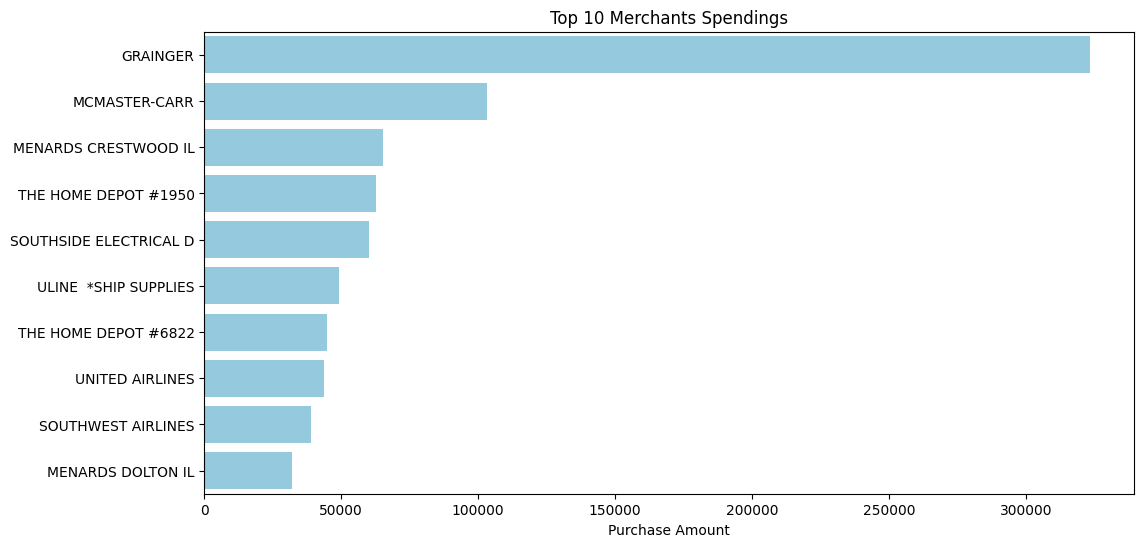

In [12]:
# Aggregate sum of purchase amounts by merchants
merchant_aggregates = df_pcard.groupby('merchant_name')['purchase_amount'].sum().reset_index()

# Plotting the total purchase amounts by merchants
top_merchants = merchant_aggregates.sort_values(by='purchase_amount', ascending=False).head(10)  

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='purchase_amount', y='merchant_name', data=top_merchants, color="skyblue")  
plt.title('Top 10 Merchants Spendings')
plt.ylabel('')
plt.xlabel('Purchase Amount')
plt.show()

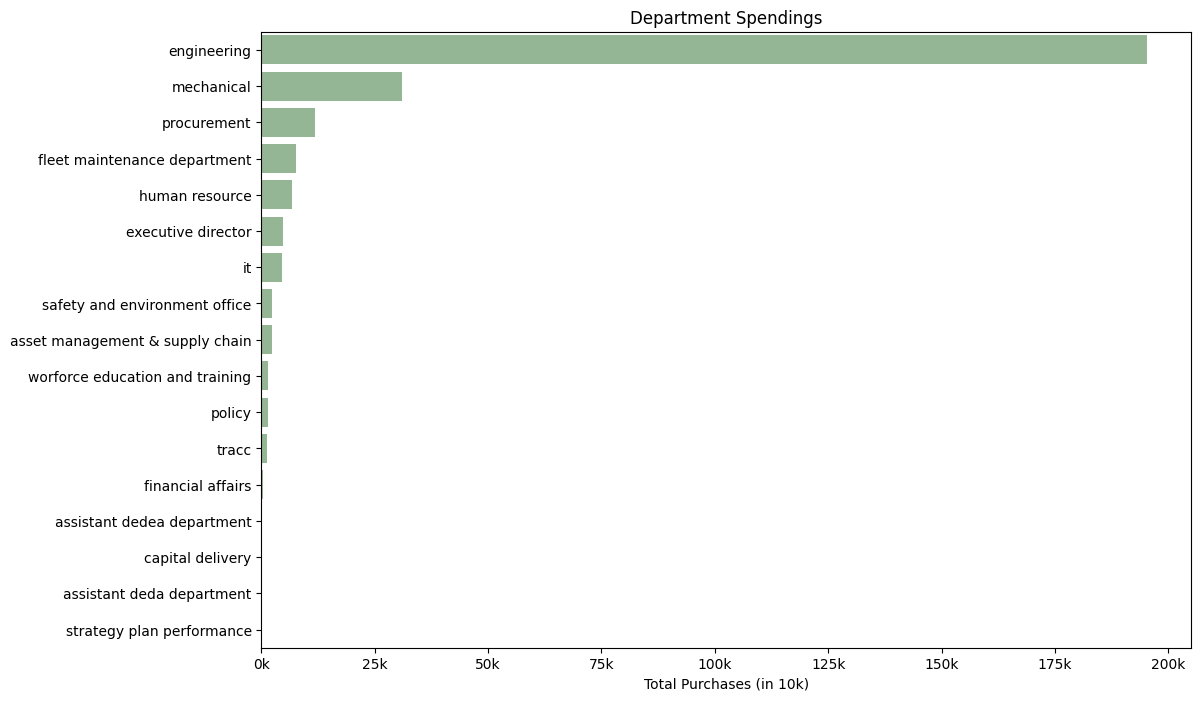

In [13]:
# Aggregate sum and mean of purchase amounts by departments
department_aggregates = df_pcard.groupby('department')['purchase_amount'].sum().reset_index()
department_aggregates = department_aggregates.sort_values(by='purchase_amount', ascending=False)

# Create a function to format the x-axis ticks into 'ten thousands' with 'k'
def thousands_formatter(x, pos):
    return f'{int(x / 10000)}k'


plt.figure(figsize=(12, 8))
ax = sns.barplot(x='purchase_amount', y='department', data=department_aggregates, color="darkseagreen")
ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
ax.set_title('Department Spendings')
ax.set_ylabel('')
ax.set_xlabel('Total Purchases (in 10k)')
plt.show()

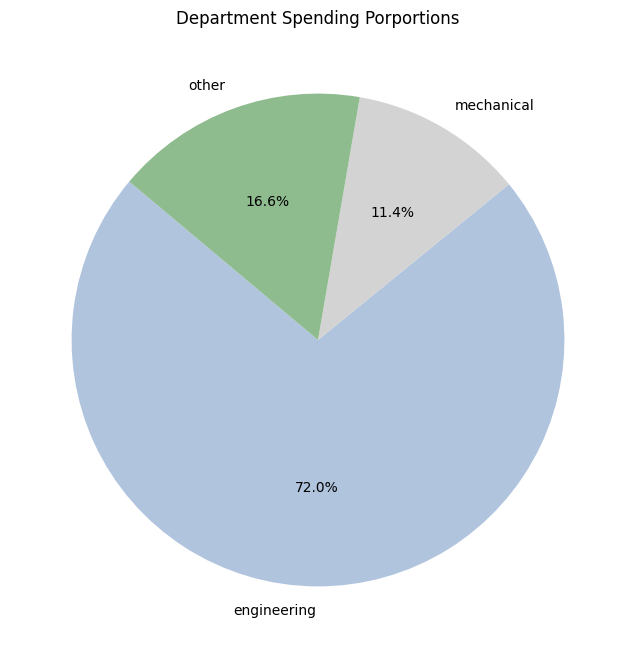

In [14]:
pie_chart = department_aggregates.set_index('department')

# Select 'engineering' and 'mechanical' explicitly and sum all others as 'other'
selected_departments = ['engineering', 'mechanical']
pie_chart['group'] = ['other' if dept not in selected_departments else dept for dept in pie_chart.index]

# Aggregate the purchase amounts
pie_chart_data = pie_chart.groupby('group')['purchase_amount'].sum()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(pie_chart_data, labels=pie_chart_data.index, autopct='%1.1f%%', startangle=140, colors=['lightsteelblue','lightgray','darkseagreen'])
plt.title('Department Spending Porportions')
plt.show()

### Step2 Key Takeways:
<br>✔️ create a Interim Metrics to have a statistics overview
<br>✔️ analyze relationship between merchants and spending amounts
<br>✔️ analyze relationship between departments and spending amounts
<br>
<br> From Department Spending bar chart and pie chart, we call tell Engineering and Mechanical are top 2 major department using P-Card. Engineering spending exceeds Merchanical by 7 times. From Top 10 Merchants Spending bar chart, we could also tell this trend. Merchants like Grainger and McMaster-Carr are siginificant Engineering department's vendors. By having this understanding, our next step is developing a model to clean vendor name.

<h2 align="center"> Step3: Model Development& Optimization </h2>

Based upon merchant_name naunce, we use one of NLP tenique TF-IDF to extract and clean merchant names.
- develope a train and test dataset
- employ data pipeline: TF-IDF and RandomForest
- optimized model by testing RandomForest node

<br>TF-IDF algorithm: TF-IDF which stands for Term Frequency - Inverse Document Frequency. This algorithm is a widely used statistical method in natural language processing and information retrieval. It measures how important a term is within a document relative to a collection of documents (i.e., relative to a corpus). TF-IDF is employed in text classification, text summarization and topic modeling which perfectly utilize into matching the messy vendor to clean vendor name.

<br>Random Forest: The random forest algorithm is an extension of the bagging method as it utilizes both bagging and feature randomness to create an uncorrelated forest of decision trees. The random forest starts by creating multiple subsets of the original dataset using bootstrapping. For each bootstrap sample, a decision tree is built. Unlike a standard decision tree that considers all possible features when splitting a node, Random Forest randomly selects a subset of features at each split. This randomness helps in making the trees less correlated and reduces the variance of the model. Once all trees are built, Random Forest aggregates their predictions. 

In [15]:
# load the training dataset
## training dataset contains meesy vendor name which is "vendor_Key" and clean labeled vendor name which is "Vendor_Name"
train_df = pd.read_csv("training_vendor_name_final_version.csv")
train_df.shape

(39915, 2)

In [16]:
train_df.head(10)

,vendor_key,vendor_name
0,(PC) 1030 EFENGEE,(pc) 1030 efengee
1,(PC) 1030 EFENGEE,(pc) 1030 efengee
2,001-RICHARDS BLDG SUPP,richards building supply
3,001-RICHARDS BLDG SUPP,richards building supply
4,001-RICHARDS BLDG SUPP,richards building supply
5,001-RICHARDS BLDG SUPP,richards building supply
6,001-RICHARDS BLDG SUPP,richards building supply
7,001-RICHARDS BLDG SUPP,richards building supply
8,001-RICHARDS BLDG SUPP,richards building supply
9,001-RICHARDS BLDG SUPP,richards building supply


In [17]:
# create a function to clean "Vendor_Key"
def clean_text(text):
    text = str(text)  # convert to string
    text = re.sub(r'\s+', ' ', text) # remove multiple space
    return (text
            .lower()  # convert to lowercase
            .strip()  # remove leading and trailing spaces
            )
    
# apply the cleaning function to the 'Vendor_Key' column
train_df['vendor_key'] = train_df['vendor_key'].apply(clean_text)

In [18]:
# create a new dataframe df1 which ensure the original df is not affected
df1 = train_df.copy()

# encode the 'Vendor_Name' column into numerical labels
label_encoder = LabelEncoder()
label_encoder.fit_transform(df1['vendor_name'])
df1['vendor_name_label'] = label_encoder.transform(df1['vendor_name'])

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df1['vendor_key'],  
    df1['vendor_name_label'], 
    test_size=0.2, 
    random_state=12272023
)


# create a pipeline with TF-IDF Vectorization and RandomForestClassifier
## n_estimators by using 50,100 and 300, the results are no significant change. Choosing n_estimators = 100 as an optimal model.
model = make_pipeline(
    TfidfVectorizer(),
    RandomForestClassifier(n_estimators=100)
)


# insert time count function to track how long this model run
start_time = time.time()

# train the model with the training dataset
model.fit(X_train, y_train)

# stop timing and print the elapsed time
elapsed_time = time.time() - start_time
print(f"Elapsed time for training and prediction: {elapsed_time:.2f} seconds")

# predict labels for the testing set
y_pred = model.predict(X_test)


Elapsed time for training and prediction: 44.77 seconds


<h2 align="center"> Step4: Model Evaluation </h2>

In [19]:
# generate a classification report
report = classification_report(y_test, y_pred, output_dict=True)

accuracy = report['accuracy']
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']
macro_f1_score = report['macro avg']['f1-score']
weighted_precision = report['weighted avg']['precision']
weighted_recall = report['weighted avg']['recall']
weighted_f1_score = report['weighted avg']['f1-score']

print(f'    accuracy: {accuracy:.2f}')
print(f'   macro avg: {macro_precision:.2f} {macro_recall:.2f} {macro_f1_score:.2f}')
print(f'weighted avg: {weighted_precision:.2f} {weighted_recall:.2f} {weighted_f1_score:.2f}')

    accuracy: 0.94
   macro avg: 0.43 0.45 0.44
weighted avg: 0.93 0.94 0.93


In [20]:
# predict the Vendor_Name for a new Vendor_Key
def predict_vendor_name(new_vendor_key):
    # apply the same preprocessing to the new vendor key
    new_vendor_key = new_vendor_key.lower()  
    # predict the class (label) for the new vendor key
    predicted_label = model.predict([new_vendor_key])[0]
    # convert the predicted label back to the original class name
    predicted_name = label_encoder.inverse_transform([predicted_label])[0]
    return predicted_name

# randomly input messy vendor name for testing
new_key = "menards crestwood il"
predicted_name = predict_vendor_name(new_key)
print(f"The predicted vendor name for '{new_key}' is: {predicted_name}")

The predicted vendor name for 'menards crestwood il' is: menards


### Step3 & 4 Key Takeways:
<br>✔️ create a model piepline by using TF-IDF and RandomForest
<br>✔️ use classification report to evaluate model accuracy
<br>
<br> The integration of TF-IDF and a RandomForest classifier into a single pipeline significantly enhances the efficiency of cleaning and categorizing merchant names within datasets. This approach is particularly agile, capable of processing any type of merchant name from raw datasets in under one minute. The weighted average accuracy here is 0.91 which means overall the model performs well especially for those high frequent showing vendor names. In terms of macro accuracy, it calculates each individual score and average them, it would treat each vendor name equally regardless vendor names frequency.

<h2 align="center"> Step 5: Model Implementation </h2>

In [21]:
# create a new dataframe df2 which ensure the original df and model are not affected
df2 = df_pcard.copy()
df2['merchant_name'] = df2['merchant_name'].apply(clean_text)

In [22]:
# apply model into df2
## predict the clean vendor names
start_time = time.time()
predicted_labels = model.predict(df2['merchant_name'])
elapsed_time = time.time() - start_time
print(f"Prediction time: {elapsed_time:.2f} seconds")

# convert the numerical labels back to vendor names
predicted_vendor_names = label_encoder.inverse_transform(predicted_labels)

# add the predictions to df2
df2['predicted_vendor_name'] = predicted_vendor_names

Prediction time: 19.98 seconds


In [23]:
# transform new data using the TF-IDF vectorizer 
tfidf_transformer = model.named_steps['tfidfvectorizer']
X_train_tfidf = tfidf_transformer.transform(X_train)  
df2_tfidf = tfidf_transformer.transform(df2['merchant_name'])

cosine_sim_scores_df2 = cosine_similarity(df2_tfidf, X_train_tfidf)

# store maximum cosine similarity scores for each vendor name
max_cosine_sim_scores_df2 = cosine_sim_scores_df2.max(axis=1)
df2['Cosine_Similarity_Score'] = max_cosine_sim_scores_df2

# check for average cosine similarity scores also
average_cosine_similarity_df2 = np.mean(max_cosine_sim_scores_df2)
print(f"Average Cosine Similarity Score for df2: {average_cosine_similarity_df2:.2f}")


Average Cosine Similarity Score for df2: 0.97


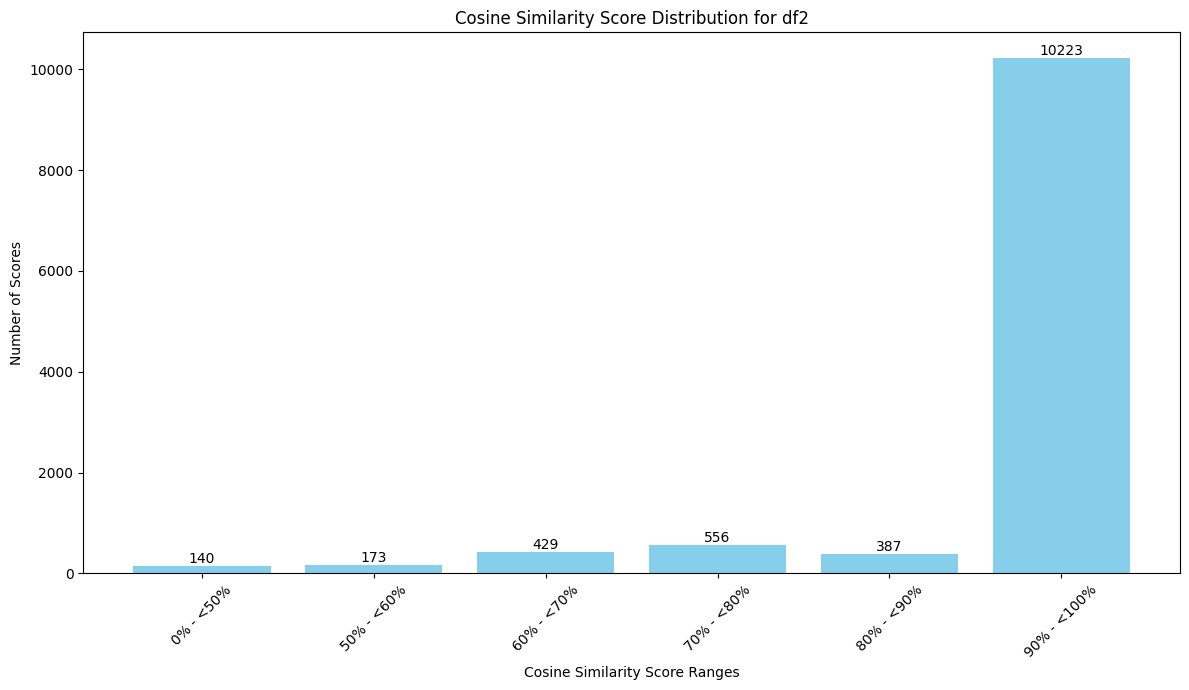

In [28]:
max_cosine_sim_scores_df2 = df2['Cosine_Similarity_Score'].values

# set thresholds
thresholds = [0.0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
counts = []

# calculate counts for each range
for i in range(len(thresholds) - 1):
    low = thresholds[i]
    high = thresholds[i + 1]
    if i == 0:
        # include scores that are exactly 0.0
        count = ((max_cosine_sim_scores_df2 >= low) & (max_cosine_sim_scores_df2 < high)).sum()
    else:
        # Exclude the lower bound
        count = ((max_cosine_sim_scores_df2 > low) & (max_cosine_sim_scores_df2 <= high)).sum()
    counts.append(count)

# labels for the ranges
labels = [f"{int(low*100)}% - <{int(high*100)}%" for low, high in zip(thresholds[:-1], thresholds[1:])]

# plotting
plt.figure(figsize=(12, 7))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Cosine Similarity Score Ranges')
plt.ylabel('Number of Scores')
plt.title('Cosine Similarity Score Distribution for df2')
plt.xticks(rotation=45)

# Adding data labels
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [29]:
# Randomly sample 10 merchant names from the 'merchant_name' column
sampled_merchant_names = df2['predicted_vendor_name'].sample(10)

# Display the randomly sampled merchant names
print(sampled_merchant_names)
df2.to_csv("df2.csv", index=False)


10020        menards
8458           store
303       home depot
6152         menards
5873          amazon
10419     home depot
6606      home depot
7922      home depot
8004     ww grainger
5184     ww grainger
Name: predicted_vendor_name, dtype: object


<h2 align="center"> Conclusion </h2>

By implementing this model pipeline, we have streamlined the process of cleaning raw datasets by accurately categorizing merchant names. This enhancement aids the Accounting department in validating P-Card transactions efficiently within set timelines. The model ensures both precision in data handling and timeliness in transaction verification, significantly improving operational efficiency and data integrity in financial workflows